# Check the classes and balance

In [8]:
from pycocotools.coco import COCO

# annotation file path
annotation_file = "/annotations/instances_val2017.json"

# Load COCO
coco = COCO(annotation_file)

# all categories
categories = coco.loadCats(coco.getCatIds())

print("COCO Class Frequencies (val2017):")
print(f"{'ID':>2s}  {'Name':<20s}  {'# Images'}")
print("-" * 40)

# Count images per class
class_frequencies = []
for cat in categories:
    cat_id = cat['id']
    name = cat['name']
    img_ids = coco.getImgIds(catIds=[cat_id])
    class_frequencies.append((cat_id, name, len(img_ids)))
    print(f"{cat_id:>2d}  {name:<20s}  {len(img_ids)}")

# Optional: sort by frequency
print("\n Top 10 Most Frequent Classes in val2017:")
for cat_id, name, freq in sorted(class_frequencies, key=lambda x: -x[2])[:10]:
    print(f"- {name:<20s} → {freq} images")


loading annotations into memory...
Done (t=0.38s)
creating index...
index created!
COCO Class Frequencies (val2017):
ID  Name                  # Images
----------------------------------------
 1  person                2693
 2  bicycle               149
 3  car                   535
 4  motorcycle            159
 5  airplane              97
 6  bus                   189
 7  train                 157
 8  truck                 250
 9  boat                  121
10  traffic light         191
11  fire hydrant          86
13  stop sign             69
14  parking meter         37
15  bench                 235
16  bird                  125
17  cat                   184
18  dog                   177
19  horse                 128
20  sheep                 65
21  cow                   87
22  elephant              89
23  bear                  49
24  zebra                 85
25  giraffe               101
27  backpack              228
28  umbrella              174
31  handbag               292
32  t

# Create segmentation masks

In [9]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from pycocotools.coco import COCO

# image path
image_dir = "/home/ravindra/VJ_technology/images/val2017"

raw_mask_dir = "masks_raw"
color_mask_dir = "masks_colored"
selected_classes = ["person", "car", "bus", "dog"]

os.makedirs(raw_mask_dir, exist_ok=True)
os.makedirs(color_mask_dir, exist_ok=True)

# === Load COCO annotations ===
coco = COCO(annotation_file)
all_categories = coco.loadCats(coco.getCatIds())
name_to_id = {cat['name']: cat['id'] for cat in all_categories}

# Filter to selected classes
selected_ids = [name_to_id[name] for name in selected_classes]
cat_id_to_index = {cat_id: idx + 1 for idx, cat_id in enumerate(selected_ids)}  # index starts at 1

# Define colors for visualization (R, G, B)
colors = [
    (255, 0, 0),      # person - Blue
    (0, 255, 0),      # chair - Green
    (0, 0, 255),      # car - Red
    (255, 255, 0),    # dining table - Cyan
]

# === Process Images ===
image_ids = coco.getImgIds()

for img_id in tqdm(image_ids[:5000]):
    img_info = coco.loadImgs(img_id)[0]
    file_name = img_info['file_name']
    width, height = img_info['width'], img_info['height']

    mask = np.zeros((height, width), dtype=np.uint8)           # raw mask for training
    color_mask = np.zeros((height, width, 3), dtype=np.uint8)  # color mask for visualization

    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=selected_ids)
    anns = coco.loadAnns(ann_ids)

    for ann in anns:
        cat_id = ann['category_id']
        if cat_id not in selected_ids:
            continue
        class_idx = cat_id_to_index[cat_id]
        color = colors[class_idx - 1]

        ann_mask = coco.annToMask(ann)

        # Update raw mask
        mask[ann_mask == 1] = class_idx

        # Update color mask
        for c in range(3):
            color_mask[:, :, c][ann_mask == 1] = color[c]

    # Save masks
    raw_path = os.path.join(raw_mask_dir, file_name.replace('.jpg', '.png'))
    color_path = os.path.join(color_mask_dir, file_name.replace('.jpg', '.png'))

    cv2.imwrite(raw_path, mask)
    cv2.imwrite(color_path, color_mask)


loading annotations into memory...
Done (t=0.35s)
creating index...
index created!


100%|██████████| 5000/5000 [00:25<00:00, 192.55it/s]


Scanning masks: 100%|██████████| 4000/4000 [00:06<00:00, 648.62it/s]



📊 Foreground Class Statistics (No Background):
person          : 97,569,453 pixels (82.00%) in 2166 images
car             : 6,228,353 pixels (5.23%) in 422 images
bus             : 9,326,508 pixels (7.84%) in 145 images
dog             : 5,860,913 pixels (4.93%) in 135 images


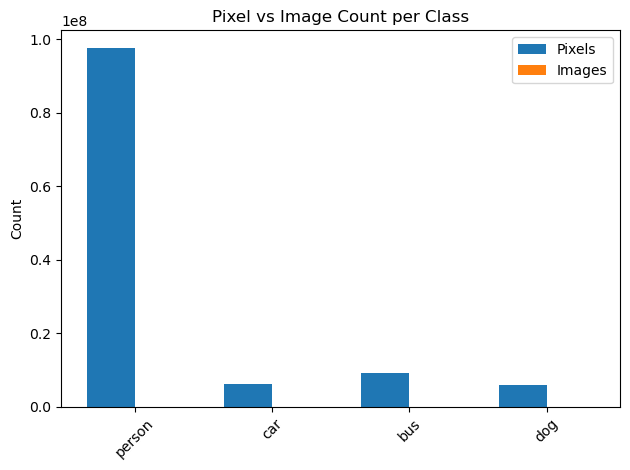

In [11]:
import os
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

# === CONFIG ===
mask_dir = "data/masks/train"
num_classes = 5  # 0 = background, 1 = person, 2 = car, 3 = bus, 4 = dog
class_names = ["person", "car", "bus", "dog"]

pixel_counts = np.zeros(num_classes - 1, dtype=np.int64)     # for classes 1–4
image_counts = np.zeros(num_classes - 1, dtype=np.int64)     # how many images contain class

mask_files = [f for f in os.listdir(mask_dir) if f.endswith('.png')]

for file in tqdm(mask_files, desc="Scanning masks"):
    mask_path = os.path.join(mask_dir, file)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    found_in_image = set()
    for cls in range(1, num_classes):  # Skip background (class 0)
        count = np.sum(mask == cls)
        pixel_counts[cls - 1] += count
        if count > 0:
            found_in_image.add(cls)

    for cls in found_in_image:
        image_counts[cls - 1] += 1

# === Print stats ===
total_fg_pixels = np.sum(pixel_counts)
print("\n📊 Foreground Class Statistics (No Background):")
for idx, cname in enumerate(class_names):
    pixel_percent = 100 * pixel_counts[idx] / total_fg_pixels
    print(f"{cname:<15} : {pixel_counts[idx]:,} pixels ({pixel_percent:.2f}%) in {image_counts[idx]} images")

# === Plot: pixels vs image count ===
x = np.arange(len(class_names))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2, pixel_counts, width, label="Pixels")
ax.bar(x + width/2, image_counts, width, label="Images")
ax.set_ylabel("Count")
ax.set_title("Pixel vs Image Count per Class")
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


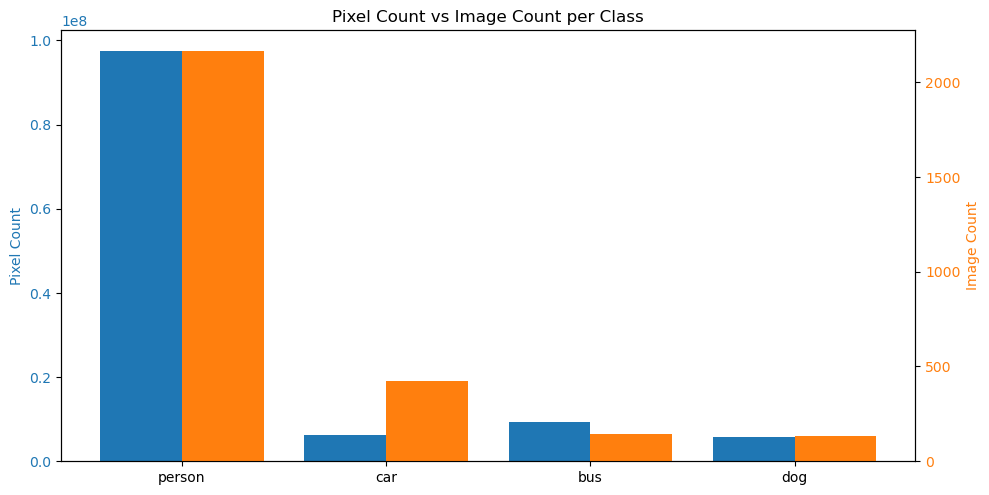

In [12]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(class_names))
width = 0.4

fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot pixel counts (left Y-axis)
bar1 = ax1.bar(x - width/2, pixel_counts, width, label='Pixel Count', color='tab:blue')
ax1.set_ylabel("Pixel Count", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Secondary Y-axis for image count
ax2 = ax1.twinx()
bar2 = ax2.bar(x + width/2, image_counts, width, label='Image Count', color='tab:orange')
ax2.set_ylabel("Image Count", color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# X-axis
plt.xticks(x, class_names, rotation=45)
fig.tight_layout()
plt.title("Pixel Count vs Image Count per Class")
plt.show()
